<a href="https://colab.research.google.com/github/ViniciusBerti/20241_maua_ecm252_intro_git/blob/main/imt_cd_ex1_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="ITM">
</head>

<img src="https://maua.br/images/selo-60-anos-maua.svg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->




# **Exercício 1 - 3o bimestre - ECM514 Ciência de Dados**

In [ ]:
#@markdown Nome completo e RA (*\<nome\>, \<RA\>*)
Aluno = 'Vinícius de Oliveira Berti, 21.01219-9' #@param {type:"string"}






# Exercício 1.

Neste exercício você fará diferentes modelos de regressão linear para estimar o peso de pinguins (`body_mass_mg`).

1. Desconsidere linhas com valores nulos (*Pre-processing*).
2. Empregue inicialmente todas as variáveis disponíveis no modelo. Para as variáveis categóricas faça o hot encode eliminando a multicolinearidade excluindo a categoria de menor valor (drop 'first') (*Pre-processing*).
3. Examine as variáveis significativas e implemente um modelo com o **`SCIKIT-LEARN`** adicionando ainda uma variável de interação entre `bill_length_mm` e `bill_depth_mm` **OU**  `bill_length_mm`,`bill_depth_mm` e `flipper_length_mm`, a que se mostrar significativa.
4. Empregue esse último modelo para prever o peso de um pinguim fêmea com medidas médias da espécie Chinstrap e compare com os valores reais.

In [ ]:
import pandas as pd
import numpy as np

path = 'https://github.com/Rogerio-mack/IMT_CD_2025/raw/refs/heads/main/data/'

df = pd.read_csv(path + 'penguins.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## Pre-Processing

In [ ]:
cols_keep = [
    'species','island','sex',
    'bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g'
]
df = df[cols_keep].copy()

df = df.dropna(subset=cols_keep).copy()

df = pd.get_dummies(
    df,
    columns=['species','island','sex'],
    drop_first=True,
    dtype=float
)

df = df.reset_index(drop=True)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

target = 'body_mass_g'

def add_inter_ld(X_df: pd.DataFrame) -> pd.DataFrame:
    X_df = X_df.copy()
    if {'bill_length_mm','bill_depth_mm'}.issubset(X_df.columns):
        X_df['bill_length_x_depth'] = X_df['bill_length_mm'] * X_df['bill_depth_mm']
    else:
        raise KeyError("As colunas 'bill_length_mm' e/ou 'bill_depth_mm' não estão no DataFrame.")
    return X_df

X = df.drop(columns=[target]).copy()
y = df[target].copy()

pipe = Pipeline(steps=[
    ('inter', FunctionTransformer(add_inter_ld, validate=False)),
    ('model', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE no conjunto de teste: {rmse:.2f} g")

RMSE no conjunto de teste: 247.40 g


In [ ]:
df_original = pd.read_csv(path + 'penguins.csv')
df_original = df_original.dropna(subset=cols_keep).copy()

g = df_original[(df_original['species'] == 'Chinstrap') & (df_original['sex'] == 'Female')]

means = {
    'bill_length_mm': g['bill_length_mm'].mean(),
    'bill_depth_mm': g['bill_depth_mm'].mean(),
    'flipper_length_mm': g['flipper_length_mm'].mean()
}
island_mode = g['island'].mode().iloc[0]

print("Medidas médias usadas:", means, "| island:", island_mode)

X_new = pd.DataFrame(0, index=[0], columns=df.drop(columns=['body_mass_g']).columns)

for col in ['bill_length_mm','bill_depth_mm','flipper_length_mm']:
    X_new[col] = means[col]

if 'species_Chinstrap' in X_new.columns:
    X_new['species_Chinstrap'] = 1
if f'island_{island_mode}' in X_new.columns:
    X_new[f'island_{island_mode}'] = 1
y_hat = pipe.predict(X_new)[0]
real_mean = g['body_mass_g'].mean()
abs_err  = abs(y_hat - real_mean)
pct_err  = abs_err / real_mean * 100

print(f"Predição do modelo: {y_hat:.0f} g")
print(f"Média real (Female, Chinstrap): {real_mean:.0f} g")
print(f"Erro absoluto: {abs_err:.0f} g | Erro %: {pct_err:.2f}%")

Medidas médias usadas: {'bill_length_mm': np.float64(46.57352941176471), 'bill_depth_mm': np.float64(17.588235294117652), 'flipper_length_mm': np.float64(191.73529411764707)} | island: Dream
Predição do modelo: 3421 g
Média real (Female, Chinstrap): 3527 g
Erro absoluto: 106 g | Erro %: 3.00%


In [ ]:
#@markdown **Check**, must be TRUE after pre-processing
display((df.sum().sum() == 1488762.5) or (df.sum().sum() == 44281742.328))


np.True_

## Feature selection

Q1. Que atributos não são significativos e qual o R2 ajustado para o modelo somente com coeficientes significativos? (**mantenha o intercept independente de ser significativo ou não**, não há pinguim de peso 0!)

In [ ]:
import statsmodels.api as sm

X = df.drop(columns=['body_mass_g'])
y = df['body_mass_g']

X = sm.add_constant(X)

model_full = sm.OLS(y, X).fit()
print(model_full.summary())

significant_vars = model_full.pvalues[model_full.pvalues < 0.05].index

if 'const' not in significant_vars:
    significant_vars = significant_vars.insert(0, 'const')

print("\nVariáveis significativas:", significant_vars.tolist())

X_sig = X[significant_vars]
model_sig = sm.OLS(y, X_sig).fit()
print(model_sig.summary())

print(f"\nR² ajustado do modelo apenas com variáveis significativas: ", round(model_sig.rsquared_adj,3))

                            OLS Regression Results                            
Dep. Variable:            body_mass_g   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     284.1
Date:                Thu, 04 Sep 2025   Prob (F-statistic):          1.85e-141
Time:                        20:56:18   Log-Likelihood:                -2353.6
No. Observations:                 333   AIC:                             4725.
Df Residuals:                     324   BIC:                             4760.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1500.0291    575.82

## Variáveis de Interação

Q2. Quais das interações  `bill_length_mm` e `bill_depth_mm` **OU**  `bill_length_mm`,`bill_depth_mm` e `flipper_length_mm` é significativa ao ser incluída no modelo? Informe o p-value encontrado para ela.

In [ ]:
import statsmodels.formula.api as smf

base_formula = (
    "body_mass_g ~ bill_length_mm + bill_depth_mm + flipper_length_mm "
    "+ species_Chinstrap + species_Gentoo + sex_Male"
)

model_ld = smf.ols(
    formula=base_formula + " + bill_length_mm:bill_depth_mm",
    data=df
).fit()
print("Interação bill_length_mm:bill_depth_mm")
print(model_ld.summary().tables[1])

model_ldf = smf.ols(
    formula=base_formula + " + bill_length_mm:bill_depth_mm:flipper_length_mm",
    data=df
).fit()
print("\nInteração bill_length_mm:bill_depth_mm:flipper_length_mm")
print(model_ldf.summary().tables[1])

Interação bill_length_mm:bill_depth_mm
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -6290.4458   1832.633     -3.432      0.001   -9895.766   -2685.126
bill_length_mm                 130.2737     41.058      3.173      0.002      49.500     211.048
bill_depth_mm                  333.9237     98.231      3.399      0.001     140.675     527.173
flipper_length_mm               16.5347      2.888      5.725      0.000      10.853      22.216
species_Chinstrap             -200.7631     82.322     -2.439      0.015    -362.715     -38.812
species_Gentoo                 923.7884    132.379      6.978      0.000     663.361    1184.216
sex_Male                       391.6035     47.370      8.267      0.000     298.413     484.794
bill_length_mm:bill_depth_mm    -6.3440      2.290     -2.770      0.006     -10.849    

## Modelo de Interação com o `scikit-learn`

Q3. Implemente o modelo de interação *obtido* com o `scikit-learn`. Qual o R2 e o coeficiente de `bill_length_mm` obtidos desse modelo?

In [ ]:
def add_inter_ld(X_df: pd.DataFrame) -> pd.DataFrame:
    X_df = X_df.copy()
    X_df['bill_length_x_depth'] = X_df['bill_length_mm'] * X_df['bill_depth_mm']
    return X_df

target = 'body_mass_g'
X = df.drop(columns=[target]).copy()
y = df[target].copy()

pipe = Pipeline(steps=[
    ('inter', FunctionTransformer(add_inter_ld, validate=False)),
    ('model', LinearRegression())
])

pipe.fit(X, y)

r2 = pipe.score(X, y)
coefs = pipe.named_steps['model'].coef_
features = pipe['inter'].transform(X).columns

coef_bill_length = dict(zip(features, coefs))['bill_length_mm']

print(f"R² do modelo: {r2:.4f}")
print(f"Coeficiente de bill_length_mm: {coef_bill_length:.4f}")

R² do modelo: 0.8782
Coeficiente de bill_length_mm: 131.9598


## Predição com o `scikit-learn`

Q4. Como o modelo de interação *obtido* qual o peso estimado de um pinguim fêmea com medidas médias da espécie Chinstrap e o valor real?  

In [ ]:
df_original = pd.read_csv(path + 'penguins.csv')
df_original = df_original.dropna(subset=cols_keep).copy()

g = df_original[(df_original['species'] == 'Chinstrap') & (df_original['sex'] == 'Female')]

means = {
    'bill_length_mm': g['bill_length_mm'].mean(),
    'bill_depth_mm': g['bill_depth_mm'].mean(),
    'flipper_length_mm': g['flipper_length_mm'].mean()
}
island_mode = g['island'].mode().iloc[0]

X_new = pd.DataFrame(0, index=[0], columns=df.drop(columns=['body_mass_g']).columns)

for col in ['bill_length_mm','bill_depth_mm','flipper_length_mm']:
    X_new[col] = means[col]

if 'species_Chinstrap' in X_new.columns:
    X_new['species_Chinstrap'] = 1
if f'island_{island_mode}' in X_new.columns:
    X_new[f'island_{island_mode}'] = 1

y_pred_single = pipe.predict(X_new)[0]

real_mean = g['body_mass_g'].mean()

print(f"previsto = {y_pred_single:.2f}")
print(f"média real = {real_mean:.2f}")

previsto = 3423.42
média real = 3527.21


# Exercício 2.

Neste exercício você vai comparar os resultados de predição de modelos estatísticos de séries temporais (ARIMA) com os de um modelo de aprendizado de máquina (regressão linear).

1. Crie dois modelos ARIMA para série de LOD - Length Of the Day acumulado. A série é estacionária para $d=2$, o primeiro modelo empregará as componentes regressiva e de médias móveis (ARIMA) unitárias. O segundo, apenas a componente regressiva (também unitária). O modelo é estimado sobre todos os dados. Calcule o erro de ajuste do modelo (RMSE).
2. Em seguida crie um modelo de regressão linear para ajustar os valores da série. Empregue 2 lag no modelo (o número de features de atraso como ensinado em aula, ver o livro de Séries Temporais, Cap. 5, Aprendizado de Máquina). O modelo é estimado sobre todos os dados. Calcule o erro de ajuste do modelo (RMSE).






In [ ]:
df = pd.read_csv('https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Data/Delta_LOD.csv',sep=';',usecols=['year', 'month', 'day', 'lod(ms)', 'sig(ms)'])
df.index = pd.to_datetime(df[["year", "month", "day"]])

ts = df[['lod(ms)']].cumsum().resample('YE').mean()
ts.head()

,lod(ms)
1962-12-31,236.279118
1963-12-31,733.407214
1964-12-31,1392.497363
1965-12-31,2144.264740
1966-12-31,2993.562956


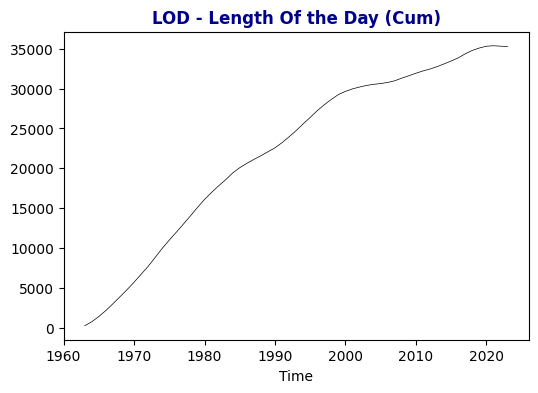

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(ts,label='Daily Cum Yearly',color='k',linestyle='-',lw=0.5)

ax.set_title('LOD - Length Of the Day (Cum)',weight='bold',color='darkblue')
ax.set_xlabel('Time')

plt.show()

## Modelos ARIMA

Q5. Qual o RMSE dos dois modelos "ARIMA" empregados? Como base no summary, explique a razão de um dos modelos ser "melhor" (menor erro)  que o outro.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

y = ts.iloc[:, 0] if isinstance(ts, pd.DataFrame) else ts
y = y.astype(float)
y.name = y.name or "lod_ms_cum"

m1 = ARIMA(y, order=(1,2,1))
res1 = m1.fit()
rmse1 = np.sqrt(np.mean(res1.resid**2))
print("M1 = ARIMA(1,2,1)  | RMSE =", round(rmse1, 3))
print(res1.summary())

m2 = ARIMA(y, order=(1,2,0))
res2 = m2.fit()
rmse2 = np.sqrt(np.mean(res2.resid**2))
print("\nM2 = ARIMA(1,2,0)  | RMSE =", round(rmse2, 3))
print(res2.summary())

better = "M1 (ARIMA(1,2,1))" if rmse1 < rmse2 else "M2 (ARIMA(1,2,0))"
print(f"\n=> Melhor (menor erro): {better}")

M1 = ARIMA(1,2,1)  | RMSE = 91.245
                               SARIMAX Results                                
Dep. Variable:                lod(ms)   No. Observations:                   61
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -335.896
Date:                Thu, 04 Sep 2025   AIC                            677.792
Time:                        20:49:17   BIC                            684.025
Sample:                    12-31-1962   HQIC                           680.225
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6349      0.246      2.576      0.010       0.152       1.118
ma.L1         -0.1899      0.302     -0.629      0.529      -0.782       0.402
sigma2      5146.

## Modelo de Regressão Linear

Q6. Qual o RMSE do modelo de Regressão Linear empregando-se 2 lags?

In [ ]:
y = ts.iloc[:, 0].astype(float)

df_lags = pd.DataFrame({
    'y': y,
    'lag1': y.shift(1),
    'lag2': y.shift(2)
}).dropna()

X = df_lags[['lag1', 'lag2']]
y_true = df_lags['y']

model = LinearRegression()
model.fit(X, y_true)

y_pred = model.predict(X)

rmse_lin = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE do modelo de Regressão Linear com 2 lags: {rmse_lin:.2f}")

RMSE do modelo de Regressão Linear com 2 lags: 71.25


## Predição

Q7. Descreva como você faria para fazer uma predição do lod acumulado até 2050 empregando o modelo de regressão linear.



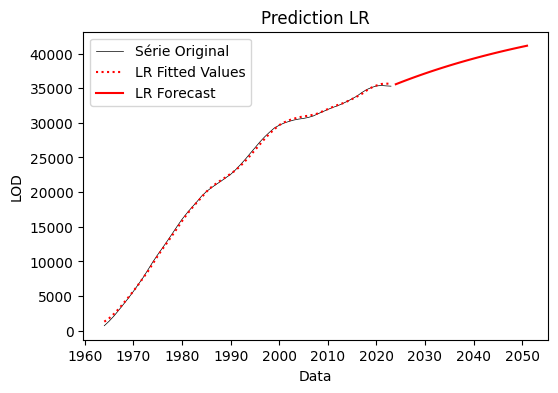